## Introduction


Customers of a bank have been segmented according to their historical operations and their background. In the objective of optimizing its development,the bank wish to move some less loyal customers to the most loyal segment. This project consist in building a score to predict the 1000 customers who are more likely to do this transition. The bank will then contact them to offer some incentives to accelerate the process. 


We have a database with thousands of customers and several variables describing their behaviour. Here are some important variables in the database (This is not an exhaustive list of the variables). 

  * Id_client: Id of the customer
  * CIBLE : The target variable. The customer have switched to the more favorable segment (0 = No/ 1= Yes)
  * Products or services withold:
     + CDD : Checking account for daily operations
     + LVA, LVB, LDD, LEP : Saving accounts available any time for some operations
     + PEL, CTO, PEA, ASV : Savings invest in less liquid assets (shares, bonds, CD...).
     + Loans 
  * Activities on the products:
     + Current : Amount of money available on the product
     + Deposit
     + Withdrawal
     
     
The complete description of all the variables in the database is in the excel file "Description Base Scoring Exam".
We have two files containing the data. One has the target variable "CIBLE". This is the one we will use to train our models and pick the best one. Then  the order file has all the variables except the variable 'CIBLE'. It is there for the application of the scoring model we chose. 


We will build the scores by estimating, for every customers, the probability to switch from the least loyal segment to the more favorable segment using a statistical model. 


Usually, a scoring model is built by following these steps:

* Construction of the database
   + Definition of the event to be studied and the eligible population
   + Definition of the study period
   + Data cleaning and construction of predictive variables
   + Separation of training set and validation set
   + Optimizing the predictive variables
   
* Modelling
   + Building multiple models
   + Choice of the "best" model
   + Interpretation of the chosen model
   
In our case, some stages of the database's construction have already been done:

* The event to be predicted is already materialized by the target variable "CIBLE" in the database. It takes values:
   + 0 if the customer has not changed segment
   + 1 if the customer has changed segment
   
* The study period has already been taken into account and all the raw variables have been included with respect to an optimal reference date. 

Therefore, we will start with the "Data cleaning and construction of explanatory variables" part. 




In [2]:
 # Important librairies needed:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     NeighbourhoodCleaningRule,EditedNearestNeighbours
                                     )
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
import scikitplot as skplt
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from plotnine import *


from datetime import datetime
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("white")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import missingno as msno
import yellowbrick
import warnings
warnings.filterwarnings('ignore')

----

## 1. Data cleaning and construction of explanatory variables

In [3]:
# We begin by loading the datasets:

# The one for building the scoring model:
customer = pd.read_csv("https://raw.githubusercontent.com/Darwin22/scoring_for_bank_customers/master/data/Base_Scoring_Exam.txt",encoding="cp1252",sep=';')

# The one for application of the chosen model:

customer_test = pd.read_csv("https://raw.githubusercontent.com/Darwin22/scoring_for_bank_customers/master/data/Base_Scoring_Exam_Test.txt",encoding="cp1252",sep=';')

### 1.1. Data cleaning and exploration

We beging by exploring the distribution of the customers according to response variable CIBLE. We see below that the response variable has imbalanced classes. This is one of the common issues when dealing with bank customer databases. In order for our model to have a good performance, we will need to address that issue using sampling methods. We will go over that later on.

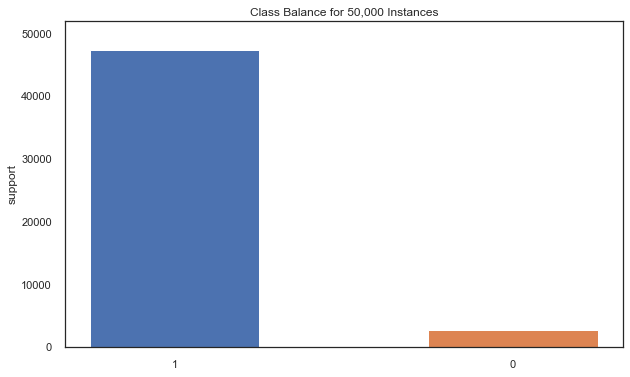

<AxesSubplot:title={'center':'Class Balance for 50,000 Instances'}, ylabel='support'>

In [4]:
plt.rcParams["figure.figsize"] = (10,6)
from yellowbrick.target import ClassBalance
# Instantiate the visualizer
visualizer_1 = ClassBalance(labels=["1", "0"])

visualizer_1.fit(customer.CIBLE)        
visualizer_1.show() 



To get some familiarity with the dataset, below I show the first 10 rows of the customer table.

In [5]:
customer.head(5)

,ID_CLIENT,CIBLE,AGE,FLAG_CLIENT,FLAG_CLIENT_M6,ANC,NB_PRODUITS,SF_TOT,SF_HORS_CDD,MT_EP_DISPO,ANC_DER_MVT,SF_TOT_M6,SF_HORS_CDD_M6,FLAG_CDD,FLAG_CBI,FLAG_VISA1,SF_CDD,SF_CDD_M6,MOY_NB_MVT_CDD_12M,MOY_MVT_CRE_CDD_12M,MOY_MVT_DEB_CDD_12M,NB_PAIEMENT_CARTE,MT_PAIEMENT_CARTE,FLAG_LVA,FLAG_LVB,FLAG_LDD,FLAG_LEP,SF_LVA,SF_LVB,SF_LDD,SF_LEP,SF_LVA_M6,SF_LVB_M6,SF_LDD_M6,SF_LEP_M6,FLAG_PEL,SF_PEL,SF_PEL_M6,FLAG_CTO,FLAG_PEA,FLAG_ASV,SF_CTO,SF_PEA,SF_ASV,SF_CTO_M6,SF_PEA_M6,SF_ASV_M6,FLAG_CONSO,FLAG_IMMO,FLAG_REVOLVING
0,17,0,72,1,1,45.833333,2,1934.67,1934.67,1934.67,4,1932.67,1934.67,1,0,0,0.00,-2.00,0.0,125.0,125.0,NaN,NaN,1,0,0,0,1934.67,NaN,NaN,NaN,1934.67,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0,0,0
1,26,0,75,1,1,53.833333,3,85844.67,49511.50,75838.17,0,83854.24,49338.25,1,0,0,36333.17,34515.99,1.0,302.0,2.0,NaN,NaN,1,0,1,1,21466.18,NaN,5769.41,12269.41,21466.18,NaN,5769.41,12269.41,0,NaN,NaN,1,0,0,10006.5,0.0,NaN,9833.25,0.0,NaN,0,0,0
2,31,0,69,1,1,38.833333,2,16470.67,16470.67,16470.67,99,16470.67,16470.67,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,16470.67,NaN,NaN,NaN,16470.67,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0,0,0
3,36,0,52,1,1,3.166667,3,47.58,10.58,47.58,1,12.58,10.58,1,0,0,37.00,2.00,1.0,5.0,2.0,0.0,0.0,1,0,0,0,10.58,NaN,NaN,NaN,10.58,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0,0,0
4,48,0,32,1,1,32.833333,2,13734.34,13734.34,13734.34,3,13234.34,13234.34,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,13734.34,NaN,NaN,NaN,13234.34,NaN,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0,0,0


**Missing Values**

Missing values is another common issue with raw data. Here is a summary of the missing values within the variables

In [6]:
customer.isnull().sum()

ID_CLIENT                  0
CIBLE                      0
AGE                        0
FLAG_CLIENT                0
FLAG_CLIENT_M6             0
ANC                        0
NB_PRODUITS                0
SF_TOT                     0
SF_HORS_CDD                0
MT_EP_DISPO                0
ANC_DER_MVT                0
SF_TOT_M6                152
SF_HORS_CDD_M6           152
FLAG_CDD                   0
FLAG_CBI                   0
FLAG_VISA1                 0
SF_CDD                 22967
SF_CDD_M6              23380
MOY_NB_MVT_CDD_12M     22967
MOY_MVT_CRE_CDD_12M    22967
MOY_MVT_DEB_CDD_12M    22967
NB_PAIEMENT_CARTE      49142
MT_PAIEMENT_CARTE      49142
FLAG_LVA                   0
FLAG_LVB                   0
FLAG_LDD                   0
FLAG_LEP                   0
SF_LVA                 10131
SF_LVB                 48335
SF_LDD                 45490
SF_LEP                 42671
SF_LVA_M6              10158
SF_LVB_M6              48374
SF_LDD_M6              45589
SF_LEP_M6     

We see below that 25% of the variables have more than 42658 missing values.

In [7]:
customer.isnull().sum().describe()

count       50.000000
mean     15839.920000
std      20762.364776
min          0.000000
25%          0.000000
50%          0.000000
75%      42658.500000
max      49142.000000
dtype: float64

We also have a summary of missing values according to the customers. We can see that 75% of the customers have less than 19 missing values over all the variables.

In [8]:
customer.isnull().sum(1).describe()

count    50000.000000
mean        15.839920
std          2.952238
min          6.000000
25%         14.000000
50%         16.000000
75%         19.000000
max         24.000000
dtype: float64

There are many methods to address the missing values. Here, as I will optimize the variables (See "Optimizing the predictive variables" part) by using data discretization, I will take care of the missing values during that part.

**Dealing with inconsistent values**

Part of the data cleaning process consist at removing and/or replacing invalid values. Here we address some of them. 

Here, 45 people with positive card payment amounts when they do not have a card are removed.


In [9]:
# 45 customers having a positive card payment amounts but do not have neither CBI nor VISA cards. 
customer = customer[-((customer.FLAG_CBI==0) & (customer.FLAG_VISA1 ==0) & (customer.MT_PAIEMENT_CARTE>0))]


Below, We remove people whose AGE is lower than ANC (Which is around 1600 rows in the dataset). ANC is the variable for Customer's seniority (in years) and cannot be greater than the customer's age.

In [10]:
customer = customer[customer.AGE > customer.ANC]

Here, we remove customers older than 85 in the database. Few of those people have made it to the next segment anyway. 

In [11]:
customer.CIBLE[customer.AGE >= 85].value_counts()

0    3165
1      81
Name: CIBLE, dtype: int64

In [12]:
customer = customer[customer.AGE <85]

We remove here the people who have a negative payment amount

In [13]:
customer = customer[-((customer.MT_PAIEMENT_CARTE <0) & (customer.FLAG_CBI==1) & (customer.FLAG_VISA1==0))]

We find here individuals with a value of 99 for the number of months since the client made a movement. Which appear to be very high, especially since the maximum recorded outside 99 is 11. Since we do not have too much information on the reliability of these data, we propose to replace 99 by the mean of this variable (Mean calculated without the 99 values). 

In [14]:
customer.ANC_DER_MVT[customer.ANC_DER_MVT == 99] = customer.ANC_DER_MVT[customer.ANC_DER_MVT!=99].mean()
customer_test.ANC_DER_MVT[customer_test.ANC_DER_MVT == 99] = customer_test.ANC_DER_MVT[customer_test.ANC_DER_MVT!=99].mean()

In [15]:
# Change categorical variables into pandas category datatype:
customer.FLAG_ASV = customer.FLAG_ASV.astype('category')
customer.FLAG_CBI = customer.FLAG_CBI.astype('category')
customer.FLAG_CDD = customer.FLAG_CDD.astype('category')
customer.FLAG_CLIENT = customer.FLAG_CLIENT.astype('category')
customer.FLAG_CLIENT_M6 = customer.FLAG_CLIENT_M6.astype('category')
customer.FLAG_CONSO = customer.FLAG_CONSO.astype('category')
customer.FLAG_CTO = customer.FLAG_CTO.astype('category')
customer.FLAG_IMMO = customer.FLAG_IMMO.astype('category')
customer.FLAG_LDD = customer.FLAG_LDD.astype('category')
customer.FLAG_LEP = customer.FLAG_LEP.astype('category')
customer.FLAG_LVA = customer.FLAG_LVA.astype('category')
customer.FLAG_LVB = customer.FLAG_LVB.astype('category')
customer.FLAG_PEA = customer.FLAG_PEA.astype('category')
customer.FLAG_PEL = customer.FLAG_PEL.astype('category')
customer.FLAG_REVOLVING = customer.FLAG_REVOLVING.astype('category')
customer.FLAG_VISA1 = customer.FLAG_VISA1.astype('category')
customer.CIBLE = customer.CIBLE.astype('category')
customer.ID_CLIENT = customer.ID_CLIENT.astype('object')


**Dealing with outliers**

Another issue can be quantitative variables having some extreme values. Here we see some examples of the distribution of variables. We have the histogram of the age and the seniority of the customers

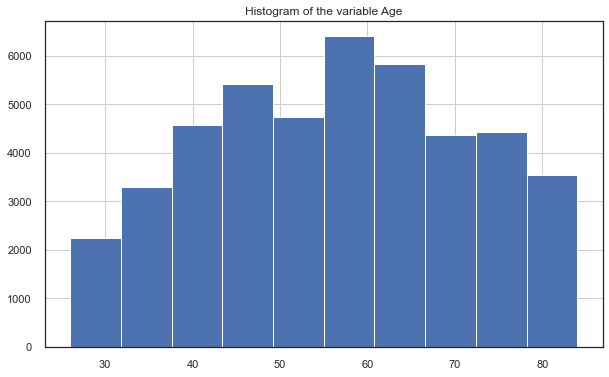

In [16]:
customer.AGE.hist()
plt.title('Histogram of the variable Age')
plt.show()

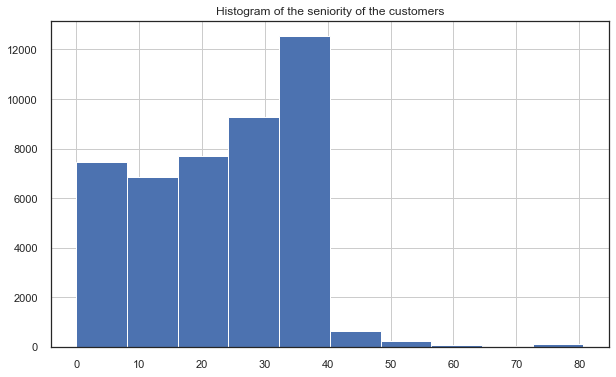

In [17]:
customer.ANC.hist()
plt.title('Histogram of the seniority of the customers')
plt.show()

We see that the distributions have a some long tails, which tells us that there is a risk of having a lot of outliers. This is the case for almost all continuous variables in the dataset. Thus, I choose to winsorize the quantitative variables, that is to say that we will try to reduce the outliers and adjust the data distribution a little by reducing the values above the 95th percentile to the 95th percentile and increase the values lower to the 5th percentile to the 5th percentile. 

In [18]:
def outliers_IQR(data, col):
    for var in col:
        lower_quartile = data[var].quantile(0.25)
        upper_quartile = data[var].quantile(0.75)
        IQR = upper_quartile - lower_quartile
        outlier_thresh = 1.5 * IQR
        data[var][data[var]>=(upper_quartile + outlier_thresh)] = data[var].quantile(0.95)
        data[var][data[var]<=(lower_quartile - outlier_thresh)] = data[var].quantile(0.05)



In [19]:
cols = ['AGE', 'ANC', 'SF_TOT', 'SF_HORS_CDD', 'MT_EP_DISPO',
       'ANC_DER_MVT', 'SF_TOT_M6', 'SF_HORS_CDD_M6', 'SF_CDD', 'SF_CDD_M6',
       'MOY_NB_MVT_CDD_12M', 'MOY_MVT_CRE_CDD_12M', 'MOY_MVT_DEB_CDD_12M',
       'MT_PAIEMENT_CARTE', 'SF_LVA', 'SF_LVB', 'SF_LDD',
       'SF_LEP', 'SF_LVA_M6', 'SF_LVB_M6', 'SF_LDD_M6', 'SF_LEP_M6', 'SF_PEL',
       'SF_PEL_M6', 'SF_CTO', 'SF_PEA', 'SF_ASV', 'SF_CTO_M6', 'SF_PEA_M6',
       'SF_ASV_M6']

In [20]:
outliers_IQR(customer,cols)

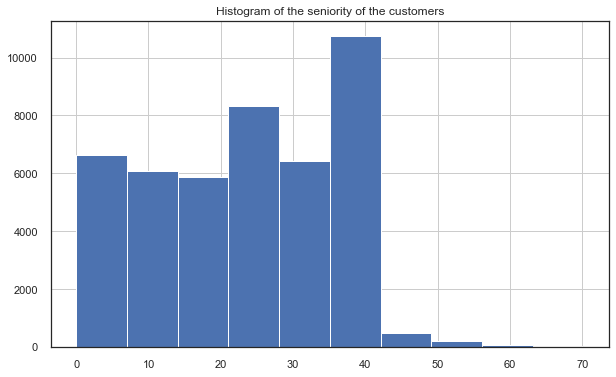

In [21]:
# For isntance, here is the new distribution of the ANC variable:
customer.ANC.hist()
plt.title('Histogram of the seniority of the customers')
plt.show()

### 1.2. Construction of new explanatory variables


In this part we create some additional features based on raw variables available in the original dataset. 


**1. NB_PEI = FLAG_PEL + FLAG_CTO + FLAG_PEA + FLAG_ASV**

This variable reflects the number of invested savings products held by each client. Money is a little less liquid, placed on these supports with the aim of keeping it for several years through favorable taxation.

In [22]:
customer['NB_PEI'] = customer.FLAG_PEL.astype(int) + customer.FLAG_CTO.astype(int) +customer.FLAG_PEA.astype(int) + customer.FLAG_ASV.astype(int)

**2. Moy_SF_TOT/Prod = SF_TOT/NB_PRODUITS** 

This variable reflects the average of the total balance by product.


In [23]:
customer['Moy_SF_TOT/Prod'] = customer.SF_TOT/customer.NB_PRODUITS

**3. Diff_SF_LivA = SF_LVA - SF_LVA_M6**

This variable reflects the difference between the current balance on Livret A and the balance 6 months ago.

In [24]:
customer['Diff_SF_LivA'] = customer.SF_LVA - customer.SF_LVA_M6

**4. Diff_SF_LivB = SF_LVB - SF_LVB_M6**


This variable reflects the difference between the current balance in Livret B and the balance 6 months ago.


In [25]:
customer['Diff_SF_LivB'] = customer.SF_LVB - customer.SF_LVB_M6

**5. Diff_SF_LDD = SF_LDD - SF_LDD_M6**

This variable reflects the difference between the current balance on the  Sustainable Development Booklet and the balance 6 months ago.

In [26]:
customer['Diff_SF_LDD'] = customer.SF_LDD - customer.SF_LDD_M6

**6. Diff_SF_LEP = SF_LEP - SF_LEP_M6**

This variable reflects the difference between the current balance on the "Livret d'Epargne Populaire" and the balance 6 months ago.

In [27]:
customer['Diff_SF_LEP'] = customer.SF_LEP - customer.SF_LEP_M6

**7. Diff_SF_CDD = SF_CDD - SF_CDD_M6**

This variable reflects the difference between the current balance on the CDD and the balance 6 months ago.

In [28]:
customer['Diff_SF_CDD'] = customer.SF_CDD - customer.SF_CDD_M6

**8. Diff_SF_TOT = SF_TOT - SF_TOT_M6**


This variable reflects the difference between the current customer's total balance for all products held and the total balance 6 months ago.

In [29]:
customer['Diff_SF_TOT'] = customer.SF_TOT - customer.SF_TOT_M6

**9. Diff_SF_HORS_CDD = SF_HORS_CDD - SF_HORS_CDD_M6**

This variable reflects the difference between the customer's total balance for all products held, apart from the deposit account and the total balance 6 months ago

In [30]:
customer['Diff_SF_HORS_CDD'] = customer.SF_HORS_CDD - customer.SF_HORS_CDD_M6

**10. Diff_SF_PEL = SF_PEL - SF_PEL_M6**

This variable reflects the difference between the current balance on the Housing Savings Plan in the month of the study and the balance 6 months ago.

In [31]:
customer['Diff_SF_PEL'] = customer.SF_PEL - customer.SF_PEL_M6

**11. Diff_SF_CTO = SF_CTO - SF_CTO_M6**

This variable reflects the difference between the current balance on the Ordinary Securities Account and the amount balance 6 months ago.

In [32]:
customer['Diff_SF_CTO'] = customer.SF_CTO - customer.SF_CTO_M6

**12. Diff_Mvt_Moy = MOY_MVT_CRE_CDD_12M - MOY_MVT_DEB_CDD_12M**

This variable reflects the difference between the average monthly amount over 12 months of credit movements on the deposit account and the average monthly amount over 12 months of debit movements on the deposit account.

In [33]:
customer['Diff_Mvt_Moy'] = customer.MOY_MVT_CRE_CDD_12M - customer.MOY_MVT_DEB_CDD_12M

**13. MOY_MT_EP_DISPO_ANC = MT_EP_DISPO / ANC**

This variable reflects the average savings available by year of seniority.


In [34]:
customer['MOY_MT_EP_DISPO_ANC'] = np.where(customer.ANC==0,customer.MT_EP_DISPO , customer.MT_EP_DISPO / customer.ANC)

**14. MOY_SF_TOT_ANC = SF_TOT / ANC**

This variable reflects the average of the customer's total balance for all the products held by year of seniority.

In [35]:
customer['MOY_SF_TOT_ANC'] = np.where(customer.ANC==0, customer.SF_TOT,customer.SF_TOT / customer.ANC)

**15. MOY_SF_HORS_CDD_ANC = SF_HORS_CDD / ANC**

This variable reflects the average of the customer's total balance on all the products held, excluding the deposit account by year of seniority.



In [36]:
customer['MOY_SF_HORS_CDD_ANC'] = np.where(customer.ANC==0, customer.SF_HORS_CDD, customer.SF_HORS_CDD/ customer.ANC)

**16. MOY_MOY_NB_MVT_CDD_12M_ANC = MOY_NB_MVT_CDD_12M / ANC**

This variable reflects the average of the monthly movements number over 12 months on the deposit account by year of seniority

In [37]:
customer['MOY_MOY_NB_MVT_CDD_12M_ANC'] = np.where(customer.ANC==0, customer.MOY_NB_MVT_CDD_12M, customer.MOY_NB_MVT_CDD_12M/ customer.ANC)

**17. Diff_LVA_LVB = SF_LVA - SF_LVB**

This variable reflects the difference between the current balance on the Livret A and the current on the Livret B.


In [38]:
customer['Diff_LVA_LVB']= customer.SF_LVA - customer.SF_LVB

**18. Diff_LVA_LEP = SF_LVA - SF_LEP**

This variable reflects the difference between the current balance on the Livret A and the balance on the Livret Epargne Populaire.

In [39]:
customer['Diff_LVA_LEP']= customer.SF_LVA - customer.SF_LEP

**Diff_LVB_LEP = SF_LVB - SF_LEP**

This variable reflects the difference between the current balance on the Livret B and the current balance on the Livret Epargne Populaire.

In [40]:
customer['Diff_LVB_LEP']= customer.SF_LVB - customer.SF_LEP

In [41]:
## Number of current product
customer['Nb_Prod_Encours'] = customer.FLAG_CDD.astype(int)+customer.FLAG_CBI.astype(int) +customer.FLAG_VISA1.astype(int)+customer.FLAG_LVA.astype(int) + customer.FLAG_LVB.astype(int) + customer.FLAG_LDD.astype(int) + customer.FLAG_LEP.astype(int)+customer.FLAG_PEL.astype(int)+customer.FLAG_CTO.astype(int) + customer.FLAG_PEA.astype(int) + customer.FLAG_ASV.astype(int) + customer.FLAG_CONSO.astype(int) + customer.FLAG_IMMO.astype(int)+ customer.FLAG_REVOLVING.astype(int)

-----

### 2. Optimizing the predictive variables

We begin here the process of discretization of quantitative variables. How will we proceed? We divide the variable into deciles, we calculate the percentage of customers moved to the next higher segment in each class, and we try to group together similar percentages, so that the percentages within each class are similar and the percentages from one class to another are different. Then, we evaluate this discretization in terms of discriminative power. If the discretized variable indicates a difference according to the categories of the dependent variable, it is because the discriminative power is there, otherwise we do not need to consider this variable.



Deciles for the SF_TOT variable:

In [42]:
# Deciles for the SF_TOT variable:

dec_sf_tot = pd.qcut(customer.SF_TOT[customer.SF_TOT.isnull()==False],q=10)
(pd.crosstab(customer[customer.SF_TOT.isnull()==False].CIBLE,dec_sf_tot).iloc[1,:].to_frame()/np.sum(customer.CIBLE==1)).transpose()

SF_TOT,"(-5890.481, 152.912]","(152.912, 368.684]","(368.684, 945.46]","(945.46, 2282.99]","(2282.99, 4954.15]","(4954.15, 8746.52]","(8746.52, 13636.624]","(13636.624, 16957.174]","(16957.174, 25191.236]","(25191.236, 37967.46]"
1,0.06795,0.017282,0.036135,0.044383,0.065593,0.090731,0.11194,0.116654,0.161822,0.28751


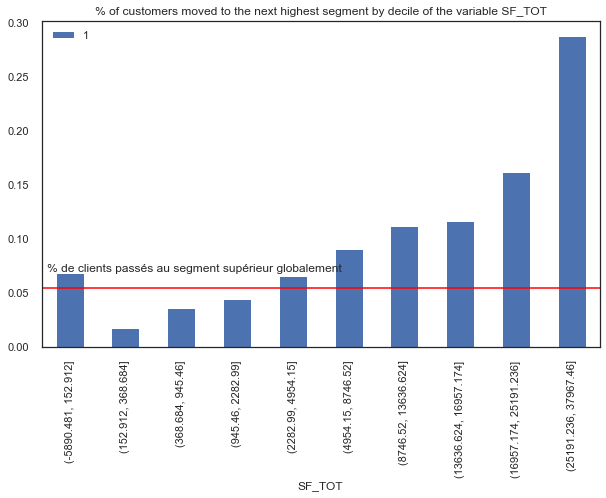

In [43]:
# see the percentage of customers moved to the next highest segment for each decile
(pd.crosstab(customer.CIBLE,dec_sf_tot).iloc[1,:].to_frame()/np.sum(customer.CIBLE==1)).plot(kind='bar')
plt.title('% of customers moved to the next highest segment by decile of the variable SF_TOT')
plt.hlines(y=0.0542288059253328, xmin=-1, xmax=10, colors='red', linestyles='solid')
plt.text(x=-0.4, y=0.07, s='% de clients passés au segment supérieur globalement')
plt.show()



Here, the deciles below the bar are put together and the others together.

In [44]:
customer['D_SF_TOT'] = 'Manquant'
customer['D_SF_TOT'][((customer.SF_TOT <= 156.912) | (customer.SF_TOT > 2282.99)) & (customer.SF_TOT.isnull()==False) ] = '< 156.912 or >2282.99'
customer['D_SF_TOT'][(customer.SF_TOT <= 2282.99) & (customer.SF_TOT > 156.912) & (customer.SF_TOT.isnull()==False)] = '156.912-2282.99'



Here, we evaluate the discriminative power of the discretized variable. We can see that discrimination is somewhat present.

In [45]:
pd.crosstab(customer.CIBLE,customer.D_SF_TOT).div(pd.crosstab(customer.CIBLE,customer.D_SF_TOT).sum(1).astype(float), axis=0)



D_SF_TOT,156.912-2282.99,< 156.912 or >2282.99
CIBLE,,
0,0.310104,0.689896
1,0.097408,0.902592


Deciles for the AGE variable:

Here, we can see that the deciles are close in each of the deciles.

In [46]:
dec_age = pd.qcut(customer.AGE[customer.AGE.isnull()==False],q=10)
(pd.crosstab(customer.CIBLE,dec_age).iloc[1,:].to_frame()/np.sum(customer.CIBLE==1)).transpose()



AGE,"(25.999, 36.0]","(36.0, 42.0]","(42.0, 47.0]","(47.0, 52.0]","(52.0, 57.0]","(57.0, 61.0]","(61.0, 65.0]","(65.0, 71.0]","(71.0, 77.0]","(77.0, 84.0]"
1,0.084839,0.079733,0.084446,0.10487,0.120581,0.120189,0.102907,0.119403,0.104478,0.078555


Deciles for the sf_hors_cdd variable:
    
    

In [47]:
dec_sf_hors_cdd = pd.qcut(customer.SF_HORS_CDD[customer.SF_HORS_CDD.isnull()==False],q=10,duplicates='drop')
(pd.crosstab(customer.CIBLE,dec_sf_hors_cdd).iloc[1,:].to_frame()/np.sum(customer.CIBLE==1)).transpose()



SF_HORS_CDD,"(-0.001, 112.918]","(112.918, 407.926]","(407.926, 1420.696]","(1420.696, 4049.86]","(4049.86, 7923.99]","(7923.99, 12791.246]","(12791.246, 16291.944]","(16291.944, 23837.224]","(23837.224, 37867.64]"
1,0.122152,0.02828,0.034564,0.05381,0.087196,0.115082,0.117439,0.155145,0.286332


In [48]:
# grouping some deciles:
customer['D_SF_HORS_CDD'] = 'Manquant'
customer['D_SF_HORS_CDD'][((customer.SF_HORS_CDD <= 112.918) | (customer.SF_HORS_CDD > 12791.246)) & (customer.SF_HORS_CDD.isnull()==False) ] = 'inf 112.918 ou sup 12791.246'
customer['D_SF_HORS_CDD'][(customer.SF_HORS_CDD <= 12791.246) & (customer.SF_HORS_CDD > 112.918) & (customer.SF_HORS_CDD.isnull()==False)] = '112.918 -12791.246'



Deciles for the MOY_MT_EP_DISPO_ANC variable:

In [49]:
dec_mt_ep_dispo_anc = pd.qcut(customer.MOY_MT_EP_DISPO_ANC[customer.MOY_MT_EP_DISPO_ANC.isnull()==False],q=10,duplicates='drop')
(pd.crosstab(customer.CIBLE,dec_mt_ep_dispo_anc).iloc[1,:].to_frame()/np.sum(customer.CIBLE==1)).transpose()



MOY_MT_EP_DISPO_ANC,"(-1962.481, 3.361]","(3.361, 12.097]","(12.097, 31.911]","(31.911, 79.44]","(79.44, 169.557]","(169.557, 307.305]","(307.305, 459.204]","(459.204, 656.899]","(656.899, 1126.293]","(1126.293, 361200.0]"
1,0.068342,0.0326,0.042812,0.05381,0.081697,0.109584,0.131972,0.139042,0.166929,0.173213


In [50]:
# grouping some deciles:
customer['D_MOY_MT_EP_DISPO_ANC'] = 'Manquant'
customer['D_MOY_MT_EP_DISPO_ANC'][(customer.MOY_MT_EP_DISPO_ANC <= 169.557) & (customer.MOY_MT_EP_DISPO_ANC.isnull()==False) ] = 'inf 169.557'
customer['D_MOY_MT_EP_DISPO_ANC'][(customer.MOY_MT_EP_DISPO_ANC > 169.557) & (customer.MOY_MT_EP_DISPO_ANC.isnull()==False)] = 'sup 169.557'

In [51]:
# Categorizing the variable NB_PRODUITS
customer['D_NB_PRODUITS'] = 'Manquant'
customer['D_NB_PRODUITS'] = np.where(customer.NB_PRODUITS > 2, '>2', '<=2')


In [52]:
# Changing these variables into categorical type:
cols_D = ['D_SF_TOT', 'D_SF_HORS_CDD', 'D_MOY_MT_EP_DISPO_ANC', 'D_NB_PRODUITS']
customer_D = customer.loc[:,cols_D]
customer_D.fillna('Manquant',inplace=True)
customer_D = customer_D.astype('category')



In [53]:
# here we are using LabelEncoder to normalize labels in the categorical variables
le= LabelEncoder()
customer_DE= customer_D[cols_D].apply(lambda col: le.fit_transform(col))
customer_DE = customer_DE.astype('category')
customer_DD = pd.get_dummies(customer_DE,drop_first=True)



In [54]:
cols_N = ['AGE', 'ANC', 'NB_PRODUITS', 'SF_TOT', 'SF_HORS_CDD', 'MT_EP_DISPO',
       'ANC_DER_MVT', 'SF_TOT_M6', 'SF_HORS_CDD_M6', 'SF_CDD', 'SF_CDD_M6',
       'MOY_NB_MVT_CDD_12M', 'MOY_MVT_CRE_CDD_12M', 'MOY_MVT_DEB_CDD_12M',
       'NB_PAIEMENT_CARTE', 'MT_PAIEMENT_CARTE', 'SF_LVA', 'SF_LVB', 'SF_LDD',
       'SF_LEP', 'SF_LVA_M6', 'SF_LVB_M6', 'SF_LDD_M6', 'SF_LEP_M6', 'SF_PEL',
       'SF_PEL_M6', 'SF_CTO', 'SF_ASV', 'SF_CTO_M6',
       'SF_ASV_M6', 'NB_PEI', 'Moy_SF_TOT/Prod', 'Diff_SF_LivA',
       'Diff_SF_LivB', 'Diff_SF_LDD', 'Diff_SF_LEP', 'Diff_SF_CDD',
       'Diff_SF_TOT', 'Diff_SF_HORS_CDD', 'Diff_SF_PEL', 'Diff_SF_CTO',
       'Diff_Mvt_Moy', 'MOY_MT_EP_DISPO_ANC',
       'MOY_SF_TOT_ANC', 'MOY_SF_HORS_CDD_ANC', 'MOY_MOY_NB_MVT_CDD_12M_ANC',
       'Diff_LVA_LVB', 'Diff_LVA_LEP', 'Diff_LVB_LEP']
customer_N = customer.loc[:,cols_N]
#from sklearn.preprocessing import StandardScaler
#client_N = pd.DataFrame(StandardScaler().fit_transform(client_N),columns = cols_N)
customer_N.fillna(-1,inplace=True)



In [55]:
cols_R = ['FLAG_CDD', 'FLAG_CBI', 'FLAG_VISA1',
 'FLAG_LVA', 'FLAG_LVB', 'FLAG_LDD', 'FLAG_LEP', 'FLAG_PEL', 'FLAG_CTO', 'FLAG_PEA', 'FLAG_ASV',
 'FLAG_CONSO', 'FLAG_IMMO', 'FLAG_REVOLVING']



In [56]:
# the final prepared dataset with the variable needed:
customer_ALL = pd.concat([customer.loc[:,cols_R].astype('category'),customer_DD.astype('category'),customer_N.astype(float)],axis=1)



Profile of customers who have changed segment

In [57]:
customer.groupby(customer.CIBLE).mean()

,AGE,ANC,NB_PRODUITS,SF_TOT,SF_HORS_CDD,MT_EP_DISPO,ANC_DER_MVT,SF_TOT_M6,SF_HORS_CDD_M6,SF_CDD,SF_CDD_M6,MOY_NB_MVT_CDD_12M,MOY_MVT_CRE_CDD_12M,MOY_MVT_DEB_CDD_12M,NB_PAIEMENT_CARTE,MT_PAIEMENT_CARTE,SF_LVA,SF_LVB,SF_LDD,SF_LEP,SF_LVA_M6,SF_LVB_M6,SF_LDD_M6,SF_LEP_M6,SF_PEL,SF_PEL_M6,SF_CTO,SF_PEA,SF_ASV,SF_CTO_M6,SF_PEA_M6,SF_ASV_M6,NB_PEI,Moy_SF_TOT/Prod,Diff_SF_LivA,Diff_SF_LivB,Diff_SF_LDD,Diff_SF_LEP,Diff_SF_CDD,Diff_SF_TOT,Diff_SF_HORS_CDD,Diff_SF_PEL,Diff_SF_CTO,Diff_Mvt_Moy,MOY_MT_EP_DISPO_ANC,MOY_SF_TOT_ANC,MOY_SF_HORS_CDD_ANC,MOY_MOY_NB_MVT_CDD_12M_ANC,Diff_LVA_LVB,Diff_LVA_LEP,Diff_LVB_LEP,Nb_Prod_Encours
CIBLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,56.296520,23.445542,2.118873,8798.619904,8063.929682,6957.828734,2.016560,8684.888672,7964.095415,1254.039866,1242.590559,7.178607,828.943600,826.881146,0.997179,292.78,6509.927754,10836.862643,3468.920761,6292.824078,6504.027765,11759.797657,3429.185749,6185.208899,16836.2319,16809.169526,8377.999196,0.0,17099.055659,8531.950002,0.0,16687.076061,0.155418,3932.962108,6.072474,-1334.892501,17.618460,86.483774,18.967912,115.673712,100.882234,451.016183,-28.646193,2.062454,694.094456,924.506773,853.285068,0.653837,1176.607009,-1106.002972,5470.691725,1.782051
1,57.518853,23.042158,2.661037,17089.960515,15752.163839,11481.224611,1.691864,16151.483155,14934.065783,1662.312638,1623.061956,9.712755,1387.530612,1373.154082,1.062500,292.78,9013.356682,13210.683095,4216.764220,7035.573459,8829.503719,13539.546581,4287.486866,6946.497769,19748.0065,19969.396816,9047.764613,0.0,18097.391861,8852.910069,0.0,17617.928525,0.423802,6316.343092,212.544497,-496.234547,2.249395,113.527336,86.177644,952.762674,837.167611,894.069302,275.651215,14.376531,1385.491625,2032.061592,1850.520911,1.158108,440.567829,-153.009133,1134.559071,2.606441


We can see here that customers who changed segment have the following characteristics:


* They have a total balance on all the products held twice as high on average as the others.

* They have a total balance on all the products held, apart from the deposit account, almost twice as high on average as the others.

* They have almost twice the amount of savings available on average than others.

* They have a slightly higher amount of available balance on their Livret A than the others.

* They have a ratio of available balance per product twice as high as the others.

* The difference between the balance on the livret A for the current month and that 6 months ago is much higher on average compared to the other customers.

* Customers in the upper segment tended to have a total number of products strictly greater than 2.






-----

### 3. Separation of training set and validation set


Here we divide our main data set into a training and testing set. (70-30)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(customer_ALL, customer.CIBLE, 
test_size = 0.3,stratify=customer.CIBLE)



In [59]:
y_train.value_counts()

0    29631
1     1782
Name: CIBLE, dtype: int64

As we saw in part 1.1, the response variable has extremely imbalanced classes. Here, we rebalance our training sample by reducing the majority class by almost 50% and adjusting the minority class to the same levelby creating synthetic data.



In [60]:
from imblearn.under_sampling import (RandomUnderSampler)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


In [61]:
X,y = RandomUnderSampler(0.1).fit_sample(X_train, y_train)
print('RUS {}'.format(Counter(y)))

X,y = SMOTETomek(1).fit_sample(X, y)
print('SMOTE {}'.format(Counter(y)))



X = pd.DataFrame(X, columns= customer_ALL.columns)

RUS Counter({0: 17820, 1: 1782})
SMOTE Counter({0: 17473, 1: 17473})


In [62]:
X.columns[X.columns.str.startswith('D_')]

Index(['D_SF_TOT_1', 'D_SF_HORS_CDD_1', 'D_MOY_MT_EP_DISPO_ANC_1',
       'D_NB_PRODUITS_1'],
      dtype='object')

In [63]:
X[cols_R]= X[cols_R].astype('category')
X[['D_SF_TOT_1', 'D_SF_HORS_CDD_1', 'D_MOY_MT_EP_DISPO_ANC_1',
       'D_NB_PRODUITS_1']]= X[['D_SF_TOT_1', 'D_SF_HORS_CDD_1', 'D_MOY_MT_EP_DISPO_ANC_1',
       'D_NB_PRODUITS_1']].astype('category')



-----

### 4. Building the scoring model

**Univariate selection of quantitative variables**


Here we make a first selection of variables. We start by analyzing the relationship between each quantitative variable and the response variable CIBLE by using statistical test on the difference of means. We will remove the variable if the test is not statistically significant. Below we show only the variables where the test is not significant.


In [64]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
Selector_f = SelectPercentile(f_classif, percentile=100)
Selector_f.fit(X.select_dtypes(np.number),y)
for n,s,p in zip(X.select_dtypes(np.number).columns,Selector_f.scores_, Selector_f.pvalues_):
    if (p>=0.05):
        print ('F_score: %3.2f et P-value == %0.3f --- for the variable %s ' % (s,p,n))

F_score: 0.04 et P-value == 0.838 --- for the variable NB_PAIEMENT_CARTE 
F_score: 0.03 et P-value == 0.865 --- for the variable Diff_SF_LivB 
F_score: 0.30 et P-value == 0.582 --- for the variable Diff_SF_LDD 
F_score: 0.11 et P-value == 0.743 --- for the variable Diff_SF_LEP 


In [65]:
# removing these variables:
X.drop(['ANC','NB_PAIEMENT_CARTE', 'MT_PAIEMENT_CARTE','Diff_LVA_LEP', 'Diff_LVB_LEP'],axis=1,inplace=True)
X_test.drop(['ANC','NB_PAIEMENT_CARTE', 'MT_PAIEMENT_CARTE','Diff_LVA_LEP', 'Diff_LVB_LEP'],axis=1,inplace=True)

**Univariate selection of qualitative variables**


We do the same for the qualitative variables, but using chi-square test this time.

In [66]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
Selector_c = SelectPercentile(chi2, percentile=100)
Selector_c.fit(X.select_dtypes('category').fillna(0),y)
for n,s,p in zip(X.select_dtypes('category').columns,Selector_c.scores_, Selector_c.pvalues_):
    if (p>0.05):
        print ('Chi-deux: %3.2f et P-value == %0.3f --- pour la variable %s ' % (s,p,n))



Chi-deux: 1.29 et P-value == 0.257 --- pour la variable FLAG_VISA1 
Chi-deux: 1.85 et P-value == 0.173 --- pour la variable FLAG_LVA 
Chi-deux: 2.29 et P-value == 0.130 --- pour la variable FLAG_LVB 


In [67]:
X.drop(['FLAG_LVA','FLAG_VISA1','FLAG_LVB'],axis=1,inplace=True)
X_test.drop(['FLAG_LVA','FLAG_VISA1','FLAG_LVB'],axis=1,inplace=True)

**Selecting variables from a recursive feature elimination**

Here we try a recursive feature elimination method  to select variables. We use a random forest model for the process.


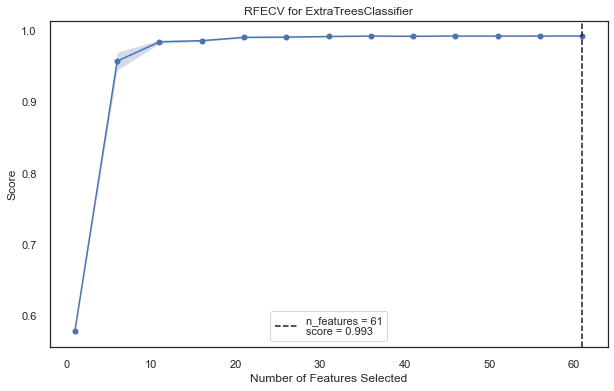

<AxesSubplot:title={'center':'RFECV for ExtraTreesClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [68]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(3,random_state=2018)
visualizer = RFECV(ExtraTreesClassifier(n_estimators=50),n_jobs=-1,cv=cv,step=5,scoring='average_precision')
visualizer.fit(X.fillna(0), y)
visualizer.show()

The graph shows us the score obtained for the average precision for each number of variables retained. The choice of the average precision is made on the basis that we are in a case of unbalanced data and that we seek to have a precise focus on class 1. The higher the average precision, the more the true 1s predicted by the models are at the level of the highest scores. If the model returns a lot of false positives before returning true positives, the average precision will be much lower.


The graph suggests that we choose 66 variables out of nearly 70 variables.It is too many variables. It can be seen from the graph that a very good average precision score is obtained for 15 variables. We will therefore move forward with 15 variables. We will use the property of decision trees with respect to the importance of variables to extract the most useful variables.





In [69]:
# here we execute the random forest model to determine the most important variables:
X = X.fillna(0)
rf =ExtraTreesClassifier(n_estimators=100).fit(X,y)



In [70]:
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
pd.DataFrame(feature_imp).transpose()

,NB_PRODUITS,D_NB_PRODUITS_1,SF_HORS_CDD,MOY_NB_MVT_CDD_12M,MOY_MVT_CRE_CDD_12M,SF_TOT,MOY_MOY_NB_MVT_CDD_12M_ANC,NB_PEI,MOY_MVT_DEB_CDD_12M,ANC_DER_MVT,SF_HORS_CDD_M6,SF_TOT_M6,AGE,MT_EP_DISPO,Moy_SF_TOT/Prod,SF_LVA,SF_LVA_M6,MOY_MT_EP_DISPO_ANC,MOY_SF_TOT_ANC,MOY_SF_HORS_CDD_ANC,Diff_SF_LivA,Diff_SF_TOT,FLAG_CDD,Diff_SF_HORS_CDD,SF_CDD,SF_CDD_M6,Diff_SF_CDD,Diff_Mvt_Moy,D_SF_TOT_1,SF_LEP_M6,SF_LEP,D_SF_HORS_CDD_1,D_MOY_MT_EP_DISPO_ANC_1,SF_LDD,SF_LDD_M6,SF_ASV,SF_ASV_M6,Diff_SF_LEP,FLAG_LDD,FLAG_LEP,FLAG_CTO,Diff_SF_LDD,FLAG_ASV,SF_CTO,FLAG_IMMO,SF_CTO_M6,FLAG_PEA,Diff_SF_CTO,FLAG_CBI,Diff_LVA_LVB,SF_PEL,SF_LVB,SF_PEL_M6,FLAG_PEL,SF_LVB_M6,Diff_SF_LivB,Diff_SF_PEL,FLAG_CONSO,FLAG_REVOLVING
0,0.128047,0.040827,0.038698,0.037908,0.036843,0.035764,0.032571,0.031081,0.030679,0.03017,0.029347,0.029097,0.027884,0.026765,0.025111,0.024864,0.023135,0.021312,0.020424,0.020397,0.019256,0.019212,0.019082,0.018846,0.017052,0.01661,0.015092,0.014775,0.013862,0.010572,0.010174,0.009911,0.009445,0.008295,0.008161,0.008156,0.006971,0.006856,0.006845,0.006661,0.006148,0.00592,0.005515,0.004822,0.004801,0.004692,0.004189,0.003804,0.003444,0.002563,0.00236,0.002176,0.002127,0.002096,0.001993,0.001982,0.001735,0.001694,0.001182


<AxesSubplot:>

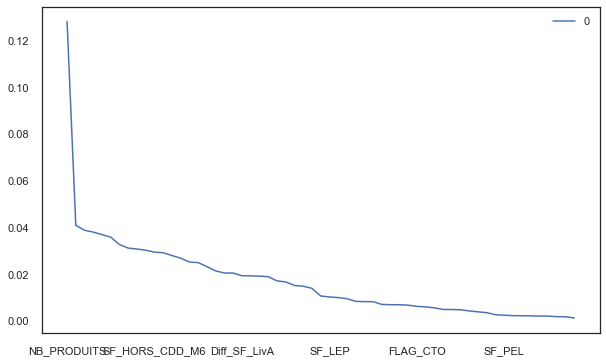

In [71]:
pd.DataFrame(feature_imp).plot()

We have here in the figure the most important to the least important variables.Consider the variables with a score greater than 0.017267

In [72]:
pd.DataFrame(feature_imp[feature_imp > 0.017267]).transpose()

,NB_PRODUITS,D_NB_PRODUITS_1,SF_HORS_CDD,MOY_NB_MVT_CDD_12M,MOY_MVT_CRE_CDD_12M,SF_TOT,MOY_MOY_NB_MVT_CDD_12M_ANC,NB_PEI,MOY_MVT_DEB_CDD_12M,ANC_DER_MVT,SF_HORS_CDD_M6,SF_TOT_M6,AGE,MT_EP_DISPO,Moy_SF_TOT/Prod,SF_LVA,SF_LVA_M6,MOY_MT_EP_DISPO_ANC,MOY_SF_TOT_ANC,MOY_SF_HORS_CDD_ANC,Diff_SF_LivA,Diff_SF_TOT,FLAG_CDD,Diff_SF_HORS_CDD
0,0.128047,0.040827,0.038698,0.037908,0.036843,0.035764,0.032571,0.031081,0.030679,0.03017,0.029347,0.029097,0.027884,0.026765,0.025111,0.024864,0.023135,0.021312,0.020424,0.020397,0.019256,0.019212,0.019082,0.018846


In [73]:
pd.DataFrame(feature_imp[feature_imp > 0.017267]).index

Index(['NB_PRODUITS', 'D_NB_PRODUITS_1', 'SF_HORS_CDD', 'MOY_NB_MVT_CDD_12M',
       'MOY_MVT_CRE_CDD_12M', 'SF_TOT', 'MOY_MOY_NB_MVT_CDD_12M_ANC', 'NB_PEI',
       'MOY_MVT_DEB_CDD_12M', 'ANC_DER_MVT', 'SF_HORS_CDD_M6', 'SF_TOT_M6',
       'AGE', 'MT_EP_DISPO', 'Moy_SF_TOT/Prod', 'SF_LVA', 'SF_LVA_M6',
       'MOY_MT_EP_DISPO_ANC', 'MOY_SF_TOT_ANC', 'MOY_SF_HORS_CDD_ANC',
       'Diff_SF_LivA', 'Diff_SF_TOT', 'FLAG_CDD', 'Diff_SF_HORS_CDD'],
      dtype='object')

In [74]:
# removing these variables: 'SF_TOT_M6', 'D_NB_PRODUITS_1','SF_HORS_CDD_M6',
X_tr = X[['NB_PRODUITS', 'MOY_NB_MVT_CDD_12M', 'SF_TOT',
       'ANC_DER_MVT', 'MOY_MOY_NB_MVT_CDD_12M_ANC', 'SF_HORS_CDD',
       'NB_PEI', 'MOY_MVT_CRE_CDD_12M',  'AGE',
       'MOY_MVT_DEB_CDD_12M', 'SF_LVA', 'Moy_SF_TOT/Prod', 'MT_EP_DISPO',
       'SF_LVA_M6', 'MOY_MT_EP_DISPO_ANC', 'MOY_SF_HORS_CDD_ANC',
       'MOY_SF_TOT_ANC', 'FLAG_CDD', 'Diff_SF_TOT', 'Diff_SF_LivA',
       'Diff_SF_HORS_CDD']]

X_te = X_test[['NB_PRODUITS', 'MOY_NB_MVT_CDD_12M', 'SF_TOT',
       'ANC_DER_MVT', 'MOY_MOY_NB_MVT_CDD_12M_ANC', 'SF_HORS_CDD',
       'NB_PEI', 'MOY_MVT_CRE_CDD_12M',  'AGE',
       'MOY_MVT_DEB_CDD_12M', 'SF_LVA', 'Moy_SF_TOT/Prod', 'MT_EP_DISPO',
       'SF_LVA_M6', 'MOY_MT_EP_DISPO_ANC', 'MOY_SF_HORS_CDD_ANC',
       'MOY_SF_TOT_ANC', 'FLAG_CDD', 'Diff_SF_TOT', 'Diff_SF_LivA',
       'Diff_SF_HORS_CDD']]

The variables are displayed in the order of their link with the dependent variable. If a quantitative variable is present as well as its discretized version, we eliminate the one that comes after. If a variable of the type "6 months ago" as well as its version for the current month are present, we remove the one which comes after in the list.


Let's see if there are other correlations that we might have missed.

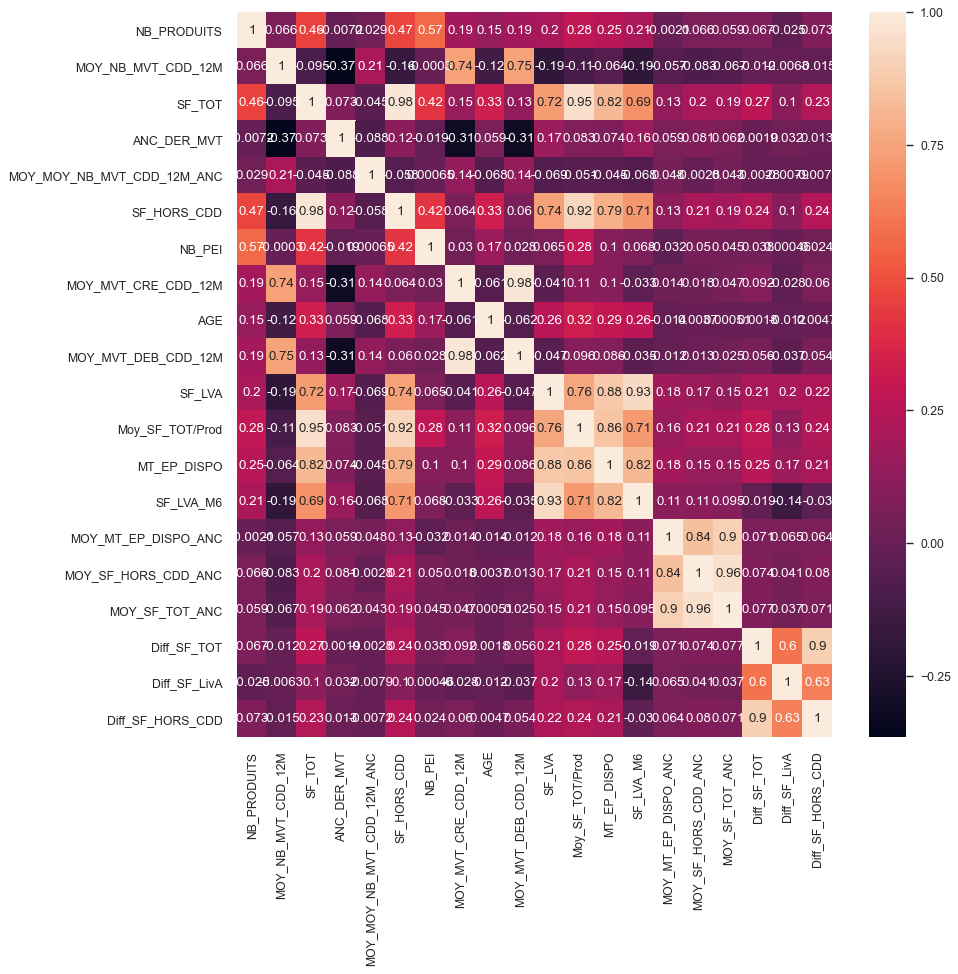

In [75]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

corr2 = X[['NB_PRODUITS', 'MOY_NB_MVT_CDD_12M', 'SF_TOT',
       'ANC_DER_MVT', 'MOY_MOY_NB_MVT_CDD_12M_ANC', 'SF_HORS_CDD',
       'NB_PEI', 'MOY_MVT_CRE_CDD_12M',  'AGE',
       'MOY_MVT_DEB_CDD_12M', 'SF_LVA', 'Moy_SF_TOT/Prod', 'MT_EP_DISPO',
       'SF_LVA_M6', 'MOY_MT_EP_DISPO_ANC', 'MOY_SF_HORS_CDD_ANC',
       'MOY_SF_TOT_ANC', 'FLAG_CDD', 'Diff_SF_TOT', 'Diff_SF_LivA',
       'Diff_SF_HORS_CDD']].corr()

sns.heatmap(corr2, annot=True, fmt=".2g")
plt.show()



From the figure above, we have identify some high correlations. Precisely, we see that: 

* SF_TOT,  Moy_SF_TOT/Prod and SF_HORS_CDD are highly correlated (Correlation greater than 0.9)
* MOY_MVT_CRE_CDD_12M and MOY_MVT_DEB_CDD_12M are highly correlated (Correlation greater than 0.9)
* SF_LVA and SF_LVA_M6 are highly correlated (Correlation greater than 0.9)
* Diff_SF_TOT and Diff_SF_HORS_CDDare highly correlated (Correlation greater than 0.9)

So in each case, we remove the one having the least importance according to the list above. 

Here are the variables we kept:

In [76]:
cols_15 = ['NB_PRODUITS', 'MOY_NB_MVT_CDD_12M', 'SF_TOT',
       'ANC_DER_MVT', 'MOY_MOY_NB_MVT_CDD_12M_ANC',
       'NB_PEI', 'MOY_MVT_CRE_CDD_12M',  'AGE',
       'SF_LVA', 'MT_EP_DISPO',
       'MOY_MT_EP_DISPO_ANC', 'MOY_SF_HORS_CDD_ANC',
       'MOY_SF_TOT_ANC', 'FLAG_CDD', 'Diff_SF_TOT', 'Diff_SF_LivA']


cols_15

['NB_PRODUITS',
 'MOY_NB_MVT_CDD_12M',
 'SF_TOT',
 'ANC_DER_MVT',
 'MOY_MOY_NB_MVT_CDD_12M_ANC',
 'NB_PEI',
 'MOY_MVT_CRE_CDD_12M',
 'AGE',
 'SF_LVA',
 'MT_EP_DISPO',
 'MOY_MT_EP_DISPO_ANC',
 'MOY_SF_HORS_CDD_ANC',
 'MOY_SF_TOT_ANC',
 'FLAG_CDD',
 'Diff_SF_TOT',
 'Diff_SF_LivA']

In [77]:
X_tr15 = X_tr[cols_15]
X_te15 = X_te[cols_15]


### Testing different models

We do the test on our cross-validation learning sample, we return the scores on the K folds and ultimately we choose the model that will provide better results on average on the samples. When this model is retained, it will be applied to the validation sample.

**Logistic Regression**

In [78]:
cv1 = StratifiedKFold(5,shuffle=True)
from sklearn.model_selection import cross_validate
lg_cv = cross_validate(LogisticRegression(solver='saga'),X=X_tr15,y=y, cv=cv1, return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))


In [79]:
pd.DataFrame(pd.DataFrame(lg_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,0.6157,0.615599,0.85748,0.857381,0.716749,0.716639,0.706476,0.706294,0.734931,0.734713


**KNeighborsClassifier**

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
knn_cv = cross_validate(KNeighborsClassifier(),X=X_tr15,y=y, cv=StratifiedShuffleSplit(3), n_jobs=-1, return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))


In [81]:
pd.DataFrame(pd.DataFrame(knn_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,0.845438,0.791535,0.958178,0.924851,0.898284,0.853014,0.964587,0.874513,0.973236,0.914611


We see that the results of the KNN for a K = 5 by default are better than the logistic regression. The area under the ROC curve averaged 91% on the cross-validation test samples against 73% for the logistic regression. The average precision reaches 87% against 70% for the logistic regression.

**Linear Discriminant Analysis (LDA)**

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ld_cv=cross_validate(LinearDiscriminantAnalysis(solver='svd'),X=X_tr15,y=y, cv=StratifiedShuffleSplit(3),n_jobs=-1, return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))

In [83]:
pd.DataFrame(pd.DataFrame(ld_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,0.750872,0.754734,0.717335,0.71448,0.733721,0.734044,0.770878,0.771099,0.810369,0.814194


**Quadratic Discriminant Analysis (QDA)**

In [84]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qd_cv=cross_validate(LinearDiscriminantAnalysis(solver='svd'),X=X_tr15,y=y, cv=StratifiedShuffleSplit(3),n_jobs=-1, return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))

In [85]:
pd.DataFrame(pd.DataFrame(qd_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,0.751284,0.753356,0.716218,0.726632,0.733332,0.739751,0.770647,0.771235,0.810248,0.813473


These results are close to logistic regression and the LDA model.

**Decision Tree Classifier**


In [86]:
from sklearn.tree import DecisionTreeClassifier
dt_cv=cross_validate(DecisionTreeClassifier(),X=X_tr15,y=y, cv=StratifiedShuffleSplit(3),n_jobs=-1, return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))

In [87]:
pd.DataFrame(pd.DataFrame(dt_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()

,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,1.0,0.89697,0.999936,0.916064,0.999968,0.906377,1.0,0.863689,1.0,0.905455


The Decision tree results seem a bit close to KNN results

**Gradient Boosting**



In [88]:
from sklearn.ensemble import GradientBoostingClassifier
gb_cv=cross_validate(GradientBoostingClassifier(),X=X_tr15,y=y, cv=StratifiedShuffleSplit(3),n_jobs=-1, return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))

In [89]:
pd.DataFrame(pd.DataFrame(gb_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()



,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,0.904627,0.900036,0.886637,0.87736,0.895541,0.888546,0.970296,0.968822,0.964167,0.963297


So far the Gradient Boosting results are the best, 96% for the area under the rock curve on average over the cross validation test samples. 96% for average precision.

**Random Forest**

In [90]:
from sklearn.model_selection import cross_validate
rf_cv = cross_validate(RandomForestClassifier(n_estimators=100),X=X_tr15,y=y,n_jobs=-1, cv=StratifiedShuffleSplit(3), return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))


In [91]:
pd.DataFrame(pd.DataFrame(rf_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()



,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,1.0,0.938247,0.999936,0.938968,0.999968,0.938607,0.999998,0.986742,0.999998,0.984886


The random forest model did better than the gradient boosting, 98% for the area under the rock curve and 98% for the average precision.

**Extra Randomized Trees**

In [92]:
from sklearn.model_selection import cross_validate
etc_cv = cross_validate(ExtraTreesClassifier(n_estimators=100),X=X_tr15,y=y,n_jobs=-1, cv=StratifiedShuffleSplit(3), return_train_score=True ,scoring=('precision', 'recall', 'f1','average_precision','roc_auc'))



In [93]:
pd.DataFrame(pd.DataFrame(etc_cv)[['train_precision','test_precision',
'train_recall','test_recall','train_f1','test_f1','train_average_precision',
'test_average_precision','train_roc_auc','test_roc_auc']].mean()).transpose()



,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_average_precision,test_average_precision,train_roc_auc,test_roc_auc
0,1.0,0.943803,0.999936,0.960893,0.999968,0.952265,1.0,0.991734,1.0,0.990585


The best model so far seems to be the Extra Randomized Trees, given the results obtained from the cross-validation.



### Application of the chosen model (validation set)

In [94]:
etcc_cv = ExtraTreesClassifier(n_estimators=100,max_depth=25,min_samples_leaf=15).fit(X=X[cols_15],y=y)
print(metrics.classification_report(y_test,etcc_cv.predict(X_te15)))


              precision    recall  f1-score   support

           0       0.98      0.84      0.90     12700
           1       0.20      0.65      0.30       764

    accuracy                           0.83     13464
   macro avg       0.59      0.74      0.60     13464
weighted avg       0.93      0.83      0.87     13464



In [95]:
print('AUC_Extra Randomized Trees : %0.3f'%(metrics.roc_auc_score(y_test,etcc_cv.predict_proba(X_te15)[:,1]),
))



AUC_Extra Randomized Trees : 0.821


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

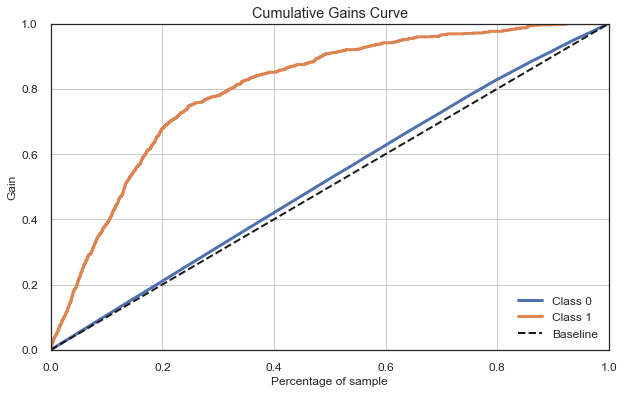

In [96]:
skplt.metrics.plot_cumulative_gain(y_test,etcc_cv.predict_proba(X_te15))



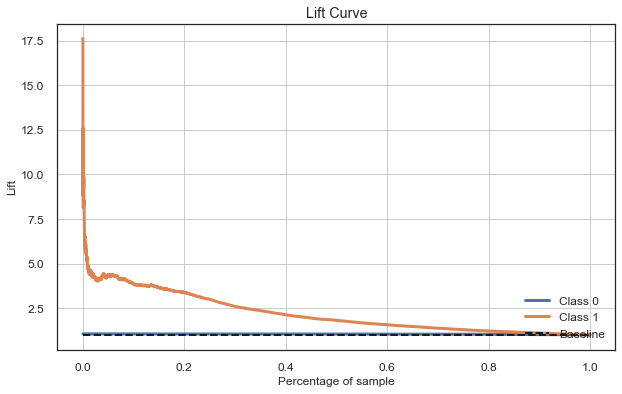

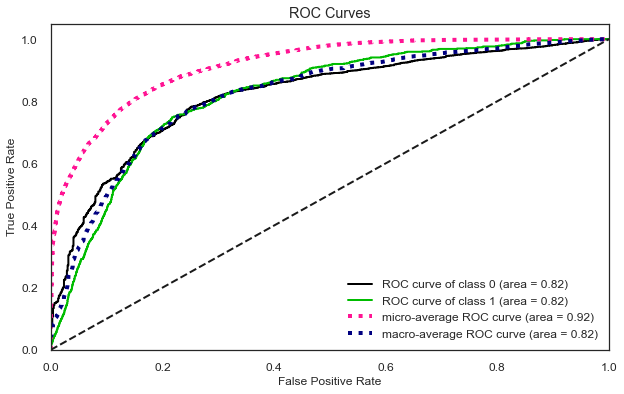

In [97]:
skplt.metrics.plot_lift_curve(y_test,etcc_cv.predict_proba(X_te15))
skplt.metrics.plot_roc(y_test,etcc_cv.predict_proba(X_te15))
plt.show()

From the cumulative gain figure above, we can see that by taking 20% of the highest scores, we capture more than 60% of customers in segment 1. We are therefore more than three times better than a trivial random model.

### 5. Conclusion

In the end, we have the cumulative gain, lift and ROC curves on the test sample. We can see that the chosen model is interesting. We had a good compromise on the precisionrecall side. Our AUC exceeds 80%, The accuray is 82%. Our lift curve tells us here that we do 3 times better than the random model in the 2nd decile (top 20%), which means that group of 20% of the customers with the highest probability predicted by our algorithm would have around a 60% (3 times the 20% mean) proportion of customers moving in the higher segment. Overall, our model behaves fine on the validation test.


In real world project, we would have apply this chosen scoring model to the customer_test dataset to select the 1000 customers with the highest likelyhood to switch over to a higher segment. Then, the bank will contact those 1000 customers to offer some special services in order to convince them to do the switch.

In [98]:
!jupyter nbconvert --to html Scoring_bank_customers.ipynb


[NbConvertApp] Converting notebook Scoring_bank_customers.ipynb to html
[NbConvertApp] Writing 1156487 bytes to Scoring_bank_customers.html
